In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import pandas as pd

from notebook_utils import *

In [3]:
all_metrics = {}

In [4]:
strategies_names = [
    "aleatoric_propagated",
    "educated_random",
    "augment_latent",
    "age",
    "anrmab",
    "entropy",
    "tta_expected_query_score",
    "random",
]
metrics_dict_cora_gcn = load_results(
    "cora_ml",
    "gcn",
    strategies_names,
    save=False,
    cached=True,
    cache_path="../other_data",
)
all_metrics[("cora_ml", "gcn")] = metrics_dict_cora_gcn

Loading cached metrics


/home/banfizsombor/work/uq-for-al-on-graphs/notebooks/notebook_utils.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metrics_dict = torch.load(metrics_path)


In [5]:
strategies_names = ["aleatoric_propagated", "age", "anrmab", "entropy", "random","approximate_uncertainty_mp"]
metrics_dict_cora_sgc = load_results(
    "cora_ml",
    "sgc",
    strategies_names,
    save=False,
    cached=False,
    cache_path="../other_data",
)
all_metrics[("cora_ml", "sgc")] = metrics_dict_cora_sgc

Loading metrics cora_ml sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
	random metrics
	approximate_uncertainty_mp metrics


In [6]:
for dataset in ["citeseer", "pubmed", "amazon_photos"]:
    for model in ["gcn", "sgc"]:
        strategies_names = ["aleatoric_propagated", "age", "anrmab", "entropy"]
        metrics_dict = load_results(
            dataset,
            model,
            strategies_names,
            save=False,
            cached=False,
            cache_path="../other_data",
        )
        all_metrics[(dataset, model)] = metrics_dict

Loading metrics citeseer gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics citeseer sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics pubmed gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics pubmed sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics amazon_photos gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics amazon_photos sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics


In [7]:
runs = combine_geem_metrics("cora_ml","geem")
agg, stds = aggregate_geem_metrics("cora_ml","geem")
# all_metrics[("cora_ml", "gcn")]["geem"] = (agg["accuracy/test"], stds["accuracy/test"], agg, runs)
all_metrics[("cora_ml", "sgc")]["geem"] = (
    agg["accuracy/test"],
    stds["accuracy/test"],
    agg,
    runs,
)

In [8]:
runs = combine_geem_metrics("cora_ml","approximate_uncertainty_esp")
agg, stds = aggregate_geem_metrics("cora_ml","approximate_uncertainty_esp")
# all_metrics[("cora_ml", "gcn")]["geem"] = (agg["accuracy/test"], stds["accuracy/test"], agg, runs)
all_metrics[("cora_ml", "sgc")]["approximate_uncertainty_esp"] = (
    agg["accuracy/test"],
    stds["accuracy/test"],
    agg,
    runs,
)

In [9]:
df_combineds = {}
for (dataset, model), metrics_dict in all_metrics.items():
    df_combined, df = create_df(metrics_dict)
    df_combineds[(dataset, model)] = (df_combined, df)

In [10]:
df_combined, df = df_combineds[("cora_ml", "gcn")]

In [11]:
strategy_mapping = {
    "aleatoric": "LC",
    "educated": "ER",
    "augment": "LC",
}

In [12]:
df_combined = []
for d_m_key in [("cora_ml", "sgc"), ("cora_ml", "gcn")]:
    # d_m_key = ("cora_ml", "sgc")
    df_tmp = df_combineds[d_m_key][0].copy()
    l = [get_count_dict(all_metrics[d_m_key][x][3]) for x in df_tmp.index]
    df_tmp["num_acquired_indices"] = [len(i[0]) for i in l]
    df_tmp["num_acquired_indices"] /= 700
    binned_stats = [
        get_count_dict_binned_stats(all_metrics[d_m_key][x][3]) for x in df_tmp.index
    ]
    df_tmp["index_original"] = df_tmp.index
    df_tmp.index = df_tmp.index.str.replace("approximate_uncertainty_", "")
    df_tmp["num_acquired_by_split"] = [i[0] for i in binned_stats]
    df_tmp["num_acquired_by_init"] = [i[1] for i in binned_stats]
    df_tmp["max_acquired"] = [i[1].max().item() for i in l]
    df_tmp["max_acquired_index"] = [i[1].argmax().item() for i in l]
    df_tmp["strategy"] = [i.split("_")[0] for i in df_tmp.index]
    df_tmp["tta"] = [
        (
            "TTA"
            if ("probs" in i) or ("logits" in i) or ("latent" in i)
            else "EQS" if "tta" in i else "NO"
        )
        for i in df_tmp.index
    ]
    df_tmp["filter"] = [True if "_filter" in i else False for i in df_tmp.index]
    if len(df_tmp.loc[(df_tmp["tta"] == "EQS"), "strategy"]) > 0:
        df_tmp.loc[(df_tmp["tta"] == "EQS"), "strategy"] = [
            x.split("_")[4] for x in df_tmp.loc[(df_tmp["tta"] == "EQS")].index
        ]
    df_tmp["adapted"] = df_tmp.index.str.contains("iquery") | df_tmp.index.str.contains(
        "itrain"
    )
    df_tmp["strategy"] = (
        df_tmp["strategy"].map(strategy_mapping).fillna(df_tmp["strategy"])
    )
    df_tmp["strategy"] = df_tmp["strategy"].str.upper()
    df_tmp["dataset"] = d_m_key[0]
    df_tmp["model"] = d_m_key[1]
    df_tmp["name_final"] = df_tmp.apply(name_fn, axis=1)
    df_tmp["name_final2"] = df_tmp["strategy"]
    df_tmp.loc[((df_tmp["name_final2"] == "LC") & (df_tmp["filter"])), "name_final2"] = (
        "LC Filtered"
    )
    
    df_tmp.index = df_tmp.index + "_" + d_m_key[1]

    df_combined.append(df_tmp)

big_cora_df = pd.concat(df_combined)

In [63]:
big_cora_df["num_diff"] = (
    big_cora_df["num_acquired_by_init"] - big_cora_df["num_acquired_by_split"]
)

In [51]:
gcn_cora_df = big_cora_df.loc[(big_cora_df["model"] == "gcn")].copy()
geem = big_cora_df.loc[(big_cora_df["strategy"] == "GEEM")].copy()
esp = big_cora_df.loc[(big_cora_df["strategy"] == "ESP")].copy()
mp = big_cora_df.loc[(big_cora_df["strategy"] == "MP")].copy()
geem = compute_stds(geem,"cora_ml", all_metrics)
esp = compute_stds(esp,"cora_ml", all_metrics)
mp = compute_stds(mp,"cora_ml", all_metrics)
gcn_cora_df = compute_stds(gcn_cora_df,"cora_ml", all_metrics)

gcn_cora_df = pd.concat([gcn_cora_df, geem, esp, mp], axis=0)
gcn_cora_df.sort_index(inplace=True)

In [107]:
highest_28_mean = gcn_cora_df.loc[gcn_cora_df.groupby("name_final")["28_mean"].idxmax()]

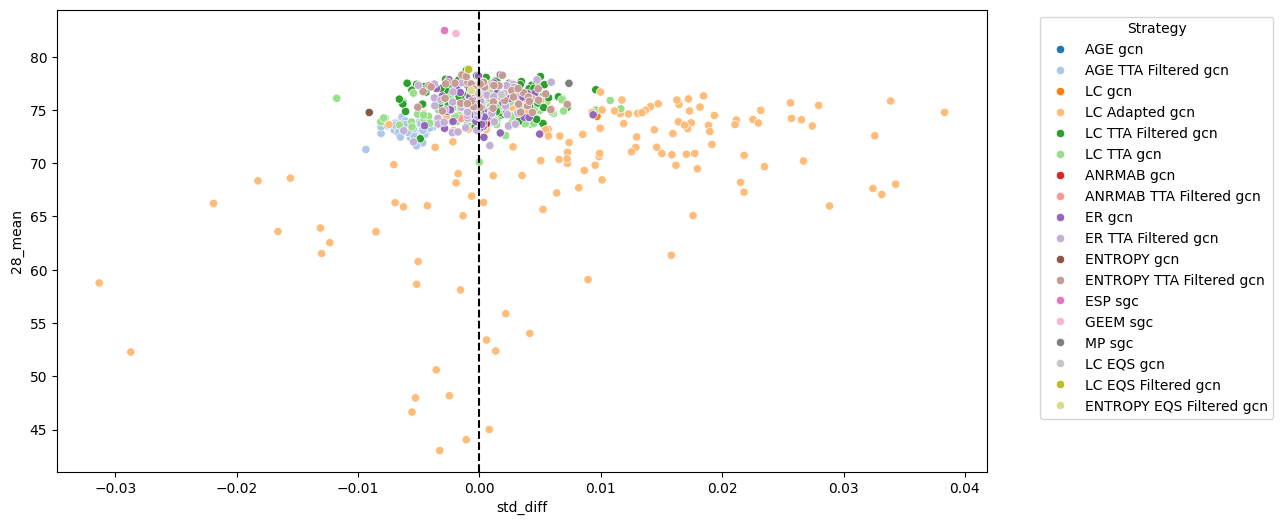

In [109]:
plt.figure(figsize=(12, 6))
# to_plot = pd.concat([gcn_cora_df[gcn_cora_df.index.str.contains("None")], highest_28_mean], axis=0)
# to_plot = highest_28_mean
to_plot = gcn_cora_df
sns.scatterplot(
    data=to_plot, x="std_diff", y="28_mean", hue="name_final", palette="tab20"
)
plt.axvline(0, color="black", linestyle="--")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Strategy")
plt.show()

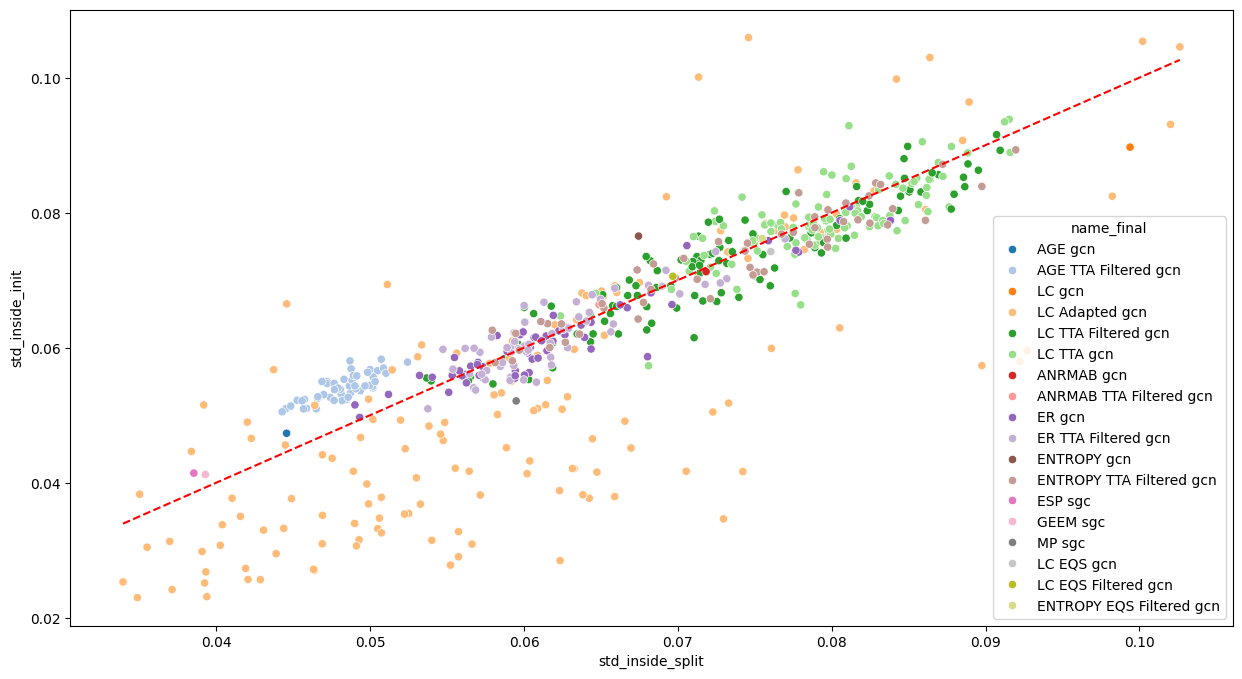

In [110]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=gcn_cora_df,
    x="std_inside_split",
    y="std_inside_init",
    hue="name_final",
    palette="tab20",
)
plt.plot(
    [gcn_cora_df["std_inside_split"].min(), gcn_cora_df["std_inside_split"].max()],
    [gcn_cora_df["std_inside_split"].min(), gcn_cora_df["std_inside_split"].max()],
    color="red",
    linestyle="--",
    label="x=y",
)

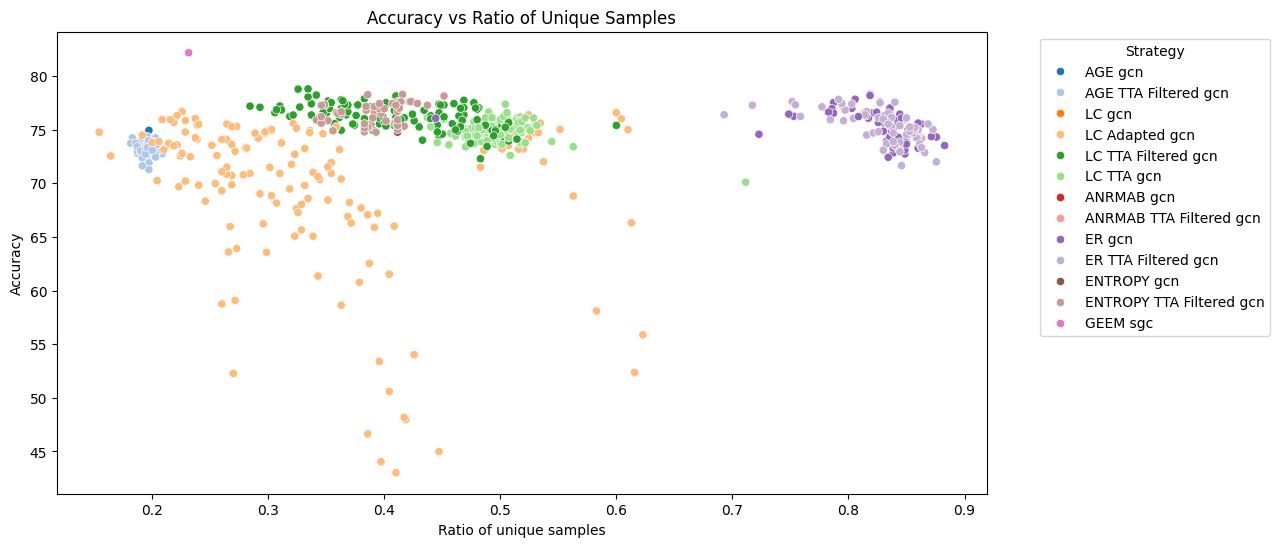

In [111]:
to_plot = big_cora_df[ ~(big_cora_df["tta"] == "EQS")  &( (big_cora_df["model"] == "gcn") |(big_cora_df["strategy"] == "GEEM")) ].copy()
to_plot.sort_index(inplace=True)
plt.figure(figsize=(12,6))
sns.scatterplot(data=to_plot, x="num_acquired_indices", y="28_mean", hue="name_final", palette="tab20")
plt.xlabel("Ratio of unique samples")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Ratio of Unique Samples")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Strategy")
# plt.legend( loc='best', title="Strategy")

plt.show()

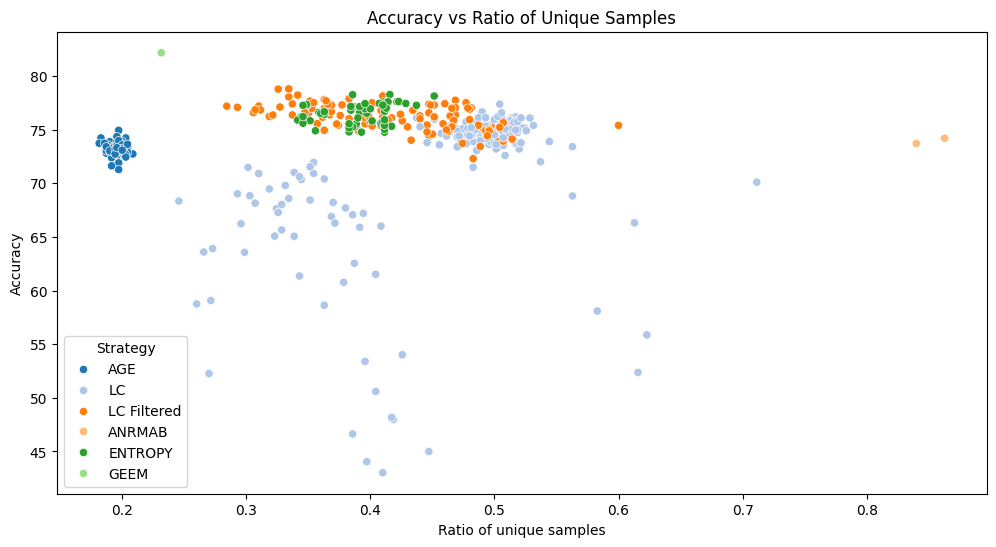

In [112]:
to_plot = big_cora_df[~big_cora_df.index.str.contains("iquery") &  ~(big_cora_df["tta"] == "EQS") & ~big_cora_df.index.str.contains("educated") &( (big_cora_df["model"] == "gcn") |(big_cora_df["strategy"] == "GEEM")) ].copy()
to_plot.sort_index(inplace=True)
plt.figure(figsize=(12,6))
sns.scatterplot(data=to_plot, x="num_acquired_indices", y="28_mean", hue="name_final2", palette="tab20")
plt.xlabel("Ratio of unique samples")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Ratio of Unique Samples")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Strategy")
plt.legend( loc='best', title="Strategy")

plt.show()

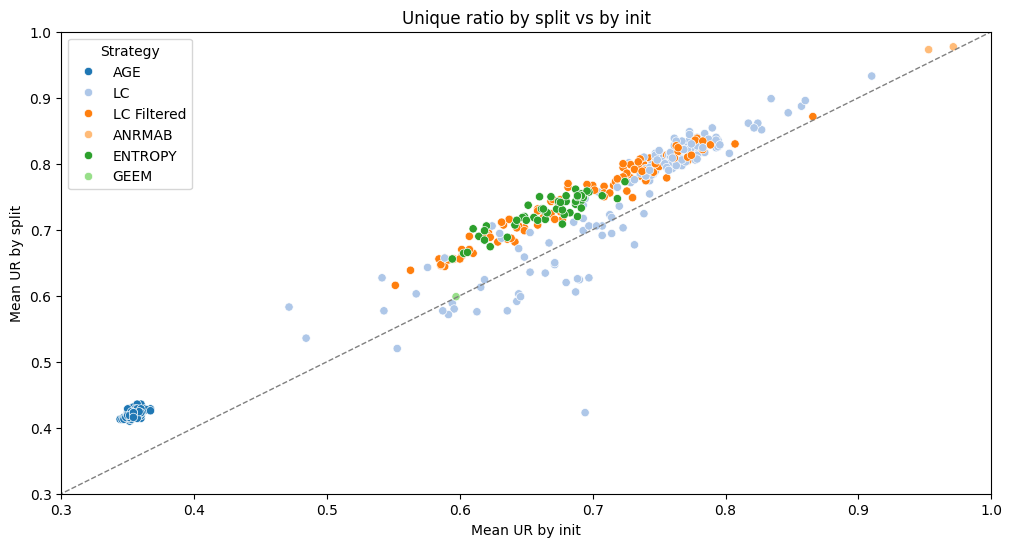

In [113]:
to_plot = big_cora_df[  ~big_cora_df.index.str.contains("iquery") &  ~(big_cora_df["tta"] == "EQS") & ~big_cora_df.index.str.contains("educated") &( (big_cora_df["model"] == "gcn") |(big_cora_df["strategy"] == "GEEM")) ].copy()
to_plot.sort_index(inplace=True)
plt.figure(figsize=(12,6))
sns.scatterplot(data=to_plot, x="num_acquired_by_split", y="num_acquired_by_init", hue="name_final2", palette="tab20")
plt.xlabel("Mean UR by init")
plt.ylabel("Mean UR by split")
plt.title("Unique ratio by split vs by init")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Strategy")
plt.legend( loc='best', title="Strategy")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=1)
plt.xlim(0.3, 1)
plt.ylim(0.3, 1)
plt.show()

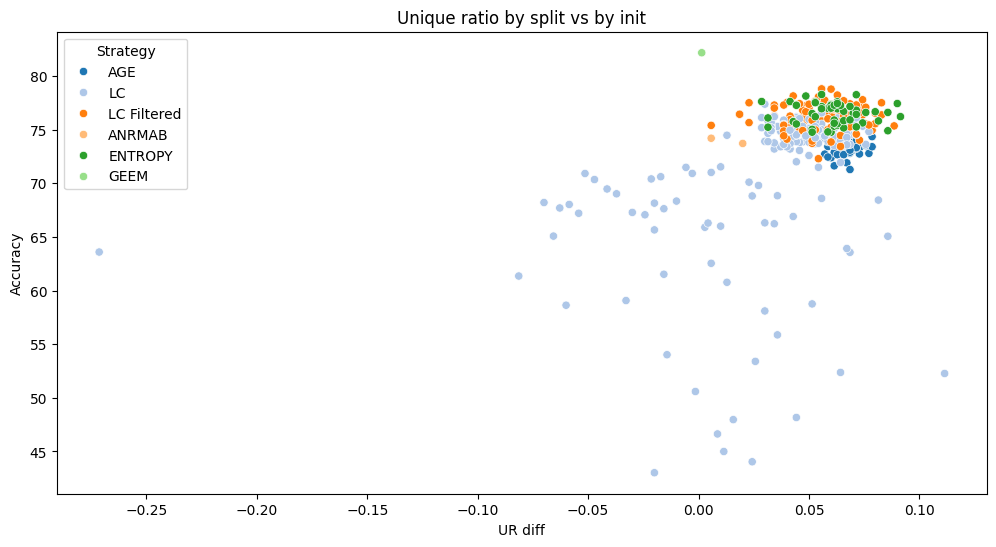

In [114]:
to_plot = big_cora_df[  ~big_cora_df.index.str.contains("iquery") &  ~(big_cora_df["tta"] == "EQS") & ~big_cora_df.index.str.contains("educated") &( (big_cora_df["model"] == "gcn") |(big_cora_df["strategy"] == "GEEM")) ].copy()
to_plot.sort_index(inplace=True)
plt.figure(figsize=(12,6))
sns.scatterplot(data=to_plot, x="num_diff", y="28_mean", hue="name_final2", palette="tab20")
plt.xlabel("UR diff")
plt.ylabel("Accuracy")
plt.title("Unique ratio by split vs by init")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Strategy")
plt.legend( loc='best', title="Strategy")

plt.show()

In [115]:
# d = []
# for k,v in metrics_dict_cora_gcn.items():
#     cd, c, i = get_count_dict(v[3])
#     d.append([k,len(cd), c.max().item(), c.argmax().item()])

# count_dict_df = pd.DataFrame(d, columns=["key", "num_acquired_indices", "max_acquisitions", "max_acquisition_index"])
# count_dict_df.sort_values(by="num_acquired_indices", ascending=True, inplace=True)
# count_dict_df

In [116]:
def jaccard_index(x, all_metrics):
    a = get_count_dict(all_metrics[("cora_ml", x["model_1"])][x["index_original_1"]][3])[
        0
    ].keys()
    b = get_count_dict(all_metrics[("cora_ml", x["model_2"])][x["index_original_2"]][3])[
        0
    ].keys()
    a = set(a)
    b = set(b)
    return len(a.intersection(b)) / len(a.union(b))


def create_jaccard_pivot(df):

    cartesian_product = pd.merge(
        df[["index_original", "model", "name_final"]].reset_index(),
        df[["index_original", "model", "name_final"]].reset_index(),
        how="cross",
        suffixes=("_1", "_2"),
    )
    cartesian_product[["index_original_1", "model_1", "index_original_2", "model_2"]]
    cartesian_product["jaccard"] = cartesian_product.apply(
        lambda x: jaccard_index(x, all_metrics), axis=1
    )
    cartesian_product.sort_values(by=["model_1", "model_2"], inplace=True)

    jaccard_pivot = cartesian_product.pivot(
        index="name_final_1",
        columns="name_final_2",
        values="jaccard",
    )
    return jaccard_pivot

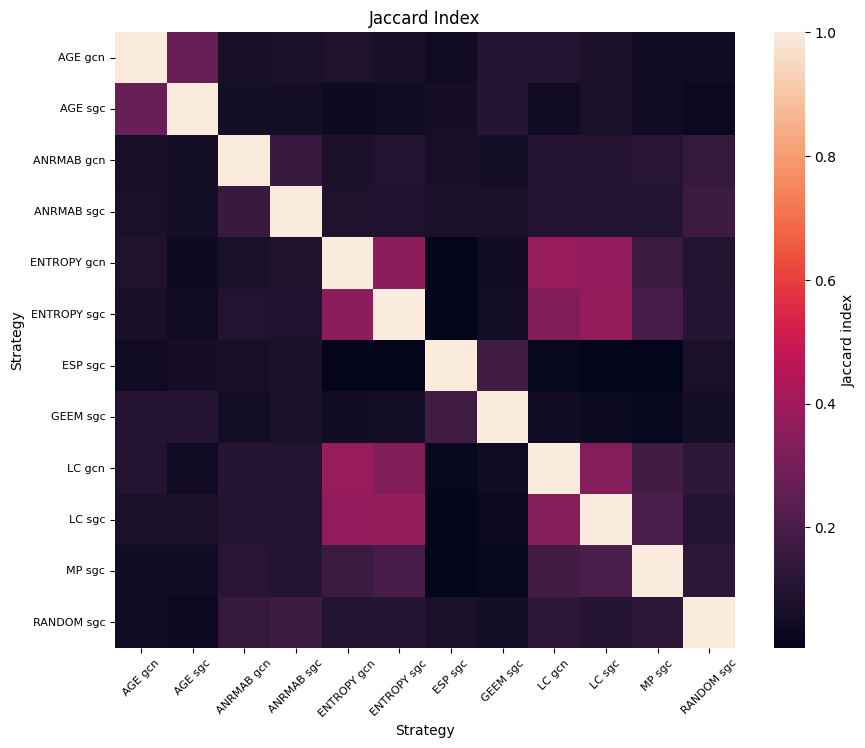

In [117]:
df = big_cora_df[
    (big_cora_df["tta"] == "NO")
    & ~big_cora_df["adapted"]
    & (big_cora_df["strategy"] != "ER")
]
jaccard_pivot_cora = create_jaccard_pivot(df)
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_pivot_cora,cbar_kws={'label': 'Jaccard index'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title("Jaccard Index")
plt.xlabel("Strategy")
plt.ylabel("Strategy")

plt.show()


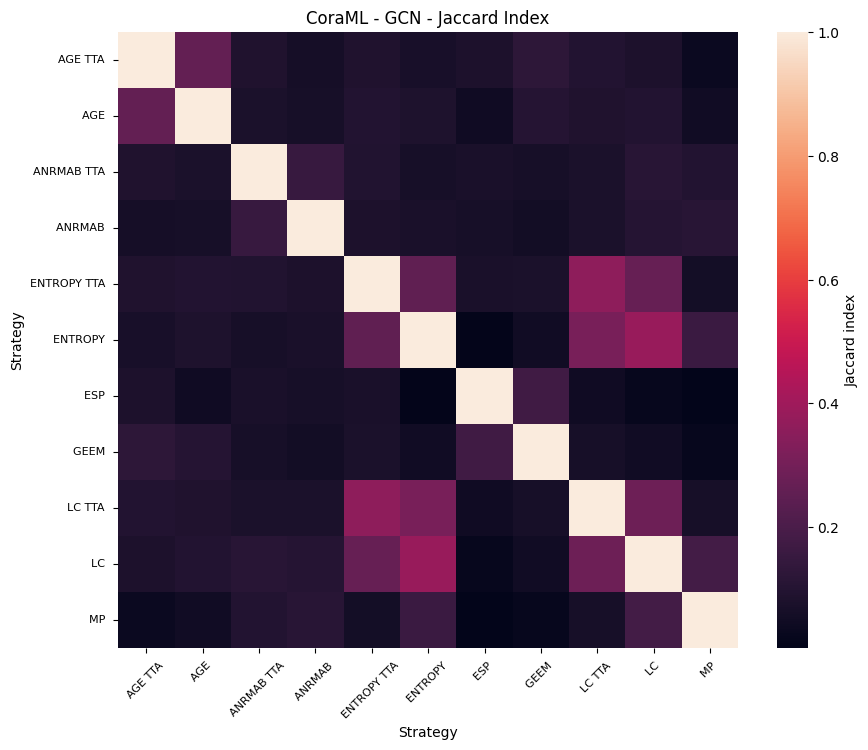

In [118]:
df = highest_28_mean[(highest_28_mean["name_final"].str.contains("TTA Filtered") | highest_28_mean["index_original"].str.contains("None")) & ~highest_28_mean["name_final"].str.contains("ER") | highest_28_mean["name_final"].str.contains("GEEM") |highest_28_mean["name_final"].str.contains("ESP") | highest_28_mean["name_final"].str.contains("MP") ]
jaccard_pivot_tta = create_jaccard_pivot(df)
jaccard_pivot_tta.index = jaccard_pivot_tta.index.str.replace("gcn|sgc|Filtered ", "", regex=True)
jaccard_pivot_tta.columns = jaccard_pivot_tta.columns.str.replace("gcn|sgc|Filtered ", "", regex=True)
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_pivot_tta,cbar_kws={'label': 'Jaccard index'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title("CoraML - GCN - Jaccard Index")
plt.xlabel("Strategy")
plt.ylabel("Strategy")

plt.show()

In [ ]:
key1 = "aleatoric_propagated_None"
key2 = "entropy_None"
d_m_key = ("cora_ml", "sgc")

count_dict_1, count_1, ixs_1 = get_count_dict(all_metrics[d_m_key][key1][3])
# count_dict_1, count_1, ixs_1 = get_count_dict(runs)
print(f"Maximally acquired index: {count_1.argmax()} with {count_1.max()} acquisitions")

count_dict_2, count_2, ixs_2 = get_count_dict(all_metrics[d_m_key][key2][3])
print(f"Maximally acquired index: {count_2.argmax()} with {count_2.max()} acquisitions")
print("------")

print(
    f"Intersection of acquired indices: {len(set(count_dict_1.keys()).intersection(set(count_dict_2.keys())))}"
)
print(
    f"Union of acquired indices: {len(set(count_dict_1.keys()).union(set(count_dict_2.keys())))}"
)
print(f"{key1} acquired indices: {len(count_dict_1)}")
print(f"{key2} acquired indices: {len(count_dict_2)}")